# Problem statement
Example 5.1 - Reinforcement Learning: An Introduction, Sutton and Barto, Second Edition - Monte Carlo

Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over.  They're playing against a fixed dealer.

Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and it's called 'usable' at 11.
This game is placed with an infinite deck. The game starts with dealer having one face up and one face down card, while player having two face up cards. The player can request additional cards (hit=1) until they decide to stop (stick=0) or exceed 21 (bust).

After the player sticks, the dealer reveals their facedown card, and draws until their sum is 17 or greater.  If the dealer goes bust the player wins.

If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, drawing is 0, and losing is -1.

The observation of a 3-tuple of: the players current sum (0-31), the dealer's one showing card (1-10 where 1 is ace),
and whether or not the player holds a usable ace (0 or 1).

In this notebook, we prediction the state value function from a sample_policy to play Blackjack card game.

In [1]:
import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 

from utils import plotting
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
env = gym.make('Blackjack-v1')

In [3]:
def epsilon_greedy_policy(action_values, epsilon, num_actions):
    """
    Creates an epsilon-greedy policy based on the given action_values and epsilon
    
    @action_values: maps from state -> action-values
    @epsilon: the probability to select a random action
    @num_actions: number of actions in the environment
    
    Returns:
        A function that takes the observation (state) as an argument and returns
        the probabilities for each action
    
    """
    def policy_fn(observation):
        actions_prob = np.ones(num_actions, dtype=float) * epsilon / num_actions
        best_action = np.argmax(action_values[observation])
        actions_prob[best_action] += (1.0 - epsilon)
        return actions_prob
    return policy_fn

In [4]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo control epsilon-greedy algorithm to find the optimal epsilon-greedy policy
    
    @env: OpenAI environment
    @num_episodes: Number of episodes to sample
    @discount_factor: Gamma discount factor
    @epsilon: the probability to select a random action
    
    Returns:
        (action_values, policy) tuple
    """
    # Keeps track of sum and count of returns to calculate 
    # the average return of each state/action pair
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)
    
    # The final action-value function
    # maps state -> (action -> action-value)
    action_values = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Get the epsilon-greedy policy to follow
    policy = epsilon_greedy_policy(action_values, epsilon, env.action_space.n)
    
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print(f"\rEpisode {i_episode}/{num_episodes}", end="")
            sys.stdout.flush()

        # Generate an episode: a tuple of (state, action, reward)
        episode = []
        state = env.reset()
        for t in range(20):
            probs = policy(state)
            # Pick a random action according to the epsilon-greedy policy probabilities
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all state/action pairs that were visited in this episode
        state_action_pairs_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in state_action_pairs_in_episode:
            state_action_pair = (state, action)
            # Find the first occurance of the state in the episode
            first_occurence_ids = next(i for i,x in enumerate(episode) if x[0] == state)
            
            # Sum up all rewards after the first occurance
            rewards_after_first_occurance = [(i, x[2]) for i,x in enumerate(episode[first_occurence_ids:])]
            G = sum([x*(discount_factor**i) for i, x in rewards_after_first_occurance])
            
            # Calculate average return for this state/action pair over all sampled episodes
            returns_sum[state_action_pair] += G
            returns_count[state_action_pair] += 1
            action_values[state][action] = returns_sum[state_action_pair] / returns_count[state_action_pair]
    
    return action_values, policy

In [5]:
action_values, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 500000/500000

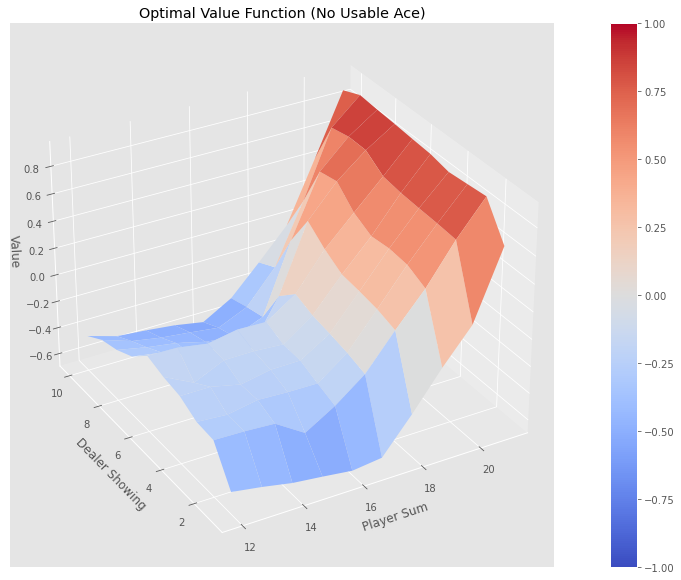

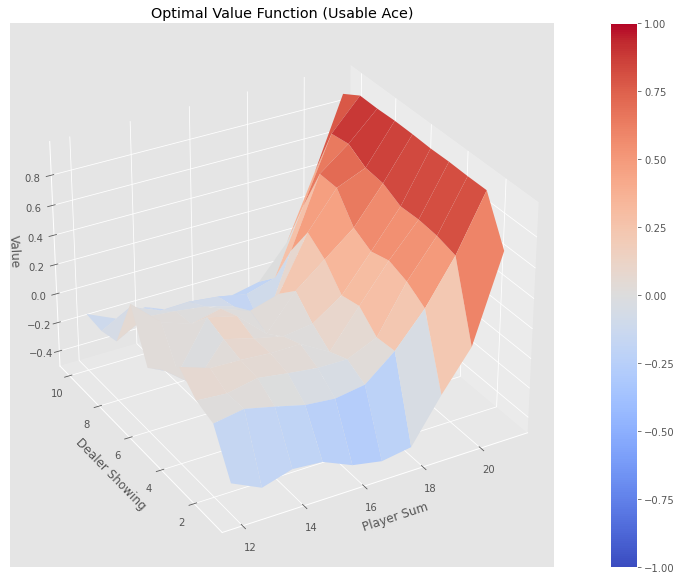

In [6]:
# Create state value function from action-value function
values = defaultdict(float)
for state, actions in action_values.items():
    action_value = np.max(actions)
    values[state] = action_value
plotting.plot_value_function(values, title="Optimal Value Function", minimum_x=12)